# NLTK + Scikit-Learn Integration

## Imports and Setup

In [413]:
# Importing libraries
import pickle
import pandas as pd
import numpy as np
import re
import nltk
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.classify.scikitlearn import SklearnClassifier
from nltk.metrics import confusionmatrix  # try using this later maybe and not just the accuracy score
from nltk.sentiment.vader import SentimentIntensityAnalyzer  # to get the sentiment score for the reviews
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC

# My own functions
from NLP_Functions import find_features, make_matrix, clean_up, tokenize, stem_and_lemmatize, remove_stopwords

In [414]:
# Importing the 5k processed comments sample DF
df = pd.read_json('Datasets/comments_5ksample.json')
df

,Title,Platform,Userscore,Comment,Username,Comments_Processed,Target
0,Dungeon Defenders,PC,8,"To me, it's a ""Meh"" game. It does include some...",DragYou,"[meh, game, doe, includ, uniqu, featur, love, ...",Pos
1,Dota 2,PC,0,"Dead game is dead, even LoL has their harrowee...",LeoneRUSSSIANS,"[dead, game, dead, even, lol, ha, harroween, g...",Neg
2,Dragon Age II,PC,5,After having played DA2 for a while and calmin...,Rosiello,"[play, da, calm, initi, rage, took, month, bel...",Pos
3,Pokemon Moon,3DS,10,Story - Very GoodOnline - All rightMusic - The...,FlaffyJasmine,"[stori, veri, goodonlin, rightmus, best, pokem...",Pos
4,Bulletstorm,PlayStation3,10,My favorite FPS of all time! A bloody and fun ...,Freddo222,"[favorit, fp, time, bloodi, fun, shooter, love...",Pos
...,...,...,...,...,...,...,...
4995,FIFA Soccer 12,PC,6,"The gameplay can be as smooth as possible, but...",Minidivine,"[gameplay, smooth, possibl, one, problem, game...",Pos
4996,Call of Duty: Modern Warfare 2,PC,0,"The lack of dedicated server support, along w...",AlanB.,"[lack, dedic, server, support, along, player, ...",Neg
4997,Grand Theft Auto IV,PlayStation3,10,"Absolutely the best game this year, last year,...",MattWix,"[absolut, best, game, thi, year, last, year, p...",Pos
4998,Grand Theft Auto: San Andreas,PC,10,The first game I played seriously.And also my ...,John67,"[first, game, play, serious, also, favorit, ma...",Pos


In [ ]:
# Testing opening the pickled naive bayes
## not using this for now
#classifier_f = open('naivebayes.pickle', 'rb')
#classifier_og = pickle.load(classifier_f)
#classifier_f.close()

#classifier_og  # this one is the trained algo with the whole comments df

## Creating the 'Target' column

para ter uma ideia do score exato posso fazer o sentiment analysis às reviews e criar uma coluna com esses valores
e depois pegar na label do classifier + o sentiment e tentar usar isso como X de um modelo de regressão e ver se ele consegue fazer algum tipo de regressão

In [415]:
# Original Labels I created previously
## Think it was 5-10 pos
## 0-4 neg
print(df['Target'].value_counts())  # 80.7% accuracy

# Changing labels to see how accuracy responds
## 9-10 positive
## 6-8 neutral
## 5 and below negative
df['Target_2'] = np.where((df['Userscore'] <= 5), 'Negative', 'Positive')
df['Target_2'] = np.where(((df['Userscore'] >= 6) & (df['Userscore'] <= 8)), 'Neutral', df['Target_2'])

df['Target_2'].value_counts()  # this made my accuracy drop to 57%!!!

Pos    4155
Neg     845
Name: Target, dtype: int64


Positive    2970
Negative    1019
Neutral     1011
Name: Target_2, dtype: int64

In [416]:
# Trying another label change to see how accuracy responds
## 9-10 positive
## 8 and below negative
df['Target_3'] = np.where((df['Userscore'] <= 8), 'Negative', 'Positive')

df['Target_3'].value_counts()  # 63.9% accuracy

Positive    2970
Negative    2030
Name: Target_3, dtype: int64

In [417]:
# 7-10 positive
# 6 and below negative
df['Target_4'] = np.where((df['Userscore'] >= 7), 'Positive', 'Negative')  # haven't tested this one yet

df['Target_4'].value_counts()

Positive    3792
Negative    1208
Name: Target_4, dtype: int64

In [418]:
# NPS Scale - https://en.wikipedia.org/wiki/Net_Promoter
#9-10 = positive
#7-8 = neutral
#0-6 = negative
df['Target_NPS'] = np.where((df['Userscore'] <= 6), 'Negative', 'Positive')
df['Target_NPS'] = np.where(((df['Userscore'] >= 7) & (df['Userscore'] <= 8)), 'Neutral', df['Target_NPS'])

df['Target_NPS'].value_counts()  # 58.9% accuracy

Positive    2970
Negative    1208
Neutral      822
Name: Target_NPS, dtype: int64

In [419]:
df.head()

,Title,Platform,Userscore,Comment,Username,Comments_Processed,Target,Target_2,Target_3,Target_4,Target_NPS
0,Dungeon Defenders,PC,8,"To me, it's a ""Meh"" game. It does include some...",DragYou,"[meh, game, doe, includ, uniqu, featur, love, ...",Pos,Neutral,Negative,Positive,Neutral
1,Dota 2,PC,0,"Dead game is dead, even LoL has their harrowee...",LeoneRUSSSIANS,"[dead, game, dead, even, lol, ha, harroween, g...",Neg,Negative,Negative,Negative,Negative
2,Dragon Age II,PC,5,After having played DA2 for a while and calmin...,Rosiello,"[play, da, calm, initi, rage, took, month, bel...",Pos,Negative,Negative,Negative,Negative
3,Pokemon Moon,3DS,10,Story - Very GoodOnline - All rightMusic - The...,FlaffyJasmine,"[stori, veri, goodonlin, rightmus, best, pokem...",Pos,Positive,Positive,Positive,Positive
4,Bulletstorm,PlayStation3,10,My favorite FPS of all time! A bloody and fun ...,Freddo222,"[favorit, fp, time, bloodi, fun, shooter, love...",Pos,Positive,Positive,Positive,Positive


## Adding Sentiment Score to the DF

In [420]:
# Adding all the sentiment scores to a single column
df['Sentiment_Score'] = df['Comment'].apply(analyzer.polarity_scores)
##df['Sentiment_Score'][0]['compound']

# Breaking down the sentiment score into a column for each of these 3 types
df['Negative_Sentiment'] = df['Sentiment_Score'].apply(lambda x: x['neg'])
df['Positive_Sentiment'] = df['Sentiment_Score'].apply(lambda x: x['pos'])
df['Compound_Sentiment'] = df['Sentiment_Score'].apply(lambda x: x['compound'])

In [421]:
# Creating a column with the comment length
## thought there could be some correlation going on here
df['Comment_Length'] = df['Comment'].apply(len)

In [422]:
# Taking a look at how the DF looks like now
df.head()

,Title,Platform,Userscore,Comment,Username,Comments_Processed,Target,Target_2,Target_3,Target_4,Target_NPS,Sentiment_Score,Negative_Sentiment,Positive_Sentiment,Compound_Sentiment,Comment_Length
0,Dungeon Defenders,PC,8,"To me, it's a ""Meh"" game. It does include some...",DragYou,"[meh, game, doe, includ, uniqu, featur, love, ...",Pos,Neutral,Negative,Positive,Neutral,"{'neg': 0.029, 'neu': 0.668, 'pos': 0.303, 'co...",0.029,0.303,0.9432,248
1,Dota 2,PC,0,"Dead game is dead, even LoL has their harrowee...",LeoneRUSSSIANS,"[dead, game, dead, even, lol, ha, harroween, g...",Neg,Negative,Negative,Negative,Negative,"{'neg': 0.25, 'neu': 0.615, 'pos': 0.135, 'com...",0.250,0.135,-0.8346,332
2,Dragon Age II,PC,5,After having played DA2 for a while and calmin...,Rosiello,"[play, da, calm, initi, rage, took, month, bel...",Pos,Negative,Negative,Negative,Negative,"{'neg': 0.147, 'neu': 0.692, 'pos': 0.162, 'co...",0.147,0.162,0.8753,2992
3,Pokemon Moon,3DS,10,Story - Very GoodOnline - All rightMusic - The...,FlaffyJasmine,"[stori, veri, goodonlin, rightmus, best, pokem...",Pos,Positive,Positive,Positive,Positive,"{'neg': 0.0, 'neu': 0.769, 'pos': 0.231, 'comp...",0.000,0.231,0.6369,109
4,Bulletstorm,PlayStation3,10,My favorite FPS of all time! A bloody and fun ...,Freddo222,"[favorit, fp, time, bloodi, fun, shooter, love...",Pos,Positive,Positive,Positive,Positive,"{'neg': 0.196, 'neu': 0.662, 'pos': 0.141, 'co...",0.196,0.141,-0.7249,380


In [433]:
# Userscore correlation with the other new columns
display(df.corr()[['Userscore']][1:])

# Whole DF correlation
df.corr()

,Userscore
Negative_Sentiment,-0.371700
Positive_Sentiment,0.358039
Compound_Sentiment,0.440986
Comment_Length,-0.090342


,Userscore,Negative_Sentiment,Positive_Sentiment,Compound_Sentiment,Comment_Length
Userscore,1.000000,-0.371700,0.358039,0.440986,-0.090342
Negative_Sentiment,-0.371700,1.000000,-0.333608,-0.608464,0.090036
Positive_Sentiment,0.358039,-0.333608,1.000000,0.558297,-0.249304
Compound_Sentiment,0.440986,-0.608464,0.558297,1.000000,0.012993
Comment_Length,-0.090342,0.090036,-0.249304,0.012993,1.000000


## Initializing the Original NLTK NB Model

In [407]:
# test the whole confusion matrix instead of just accuracy to see if it all matches nicely

# INITIALIZING EVERYTHING TO BEGIN TESTING WITH DIFFERENT MODELS

# Creating the bag of words
bow = [word for lst in df['Comments_Processed'] for word in lst]
fdist = FreqDist(bow)

# Getting just the 5k most common words
most_common = fdist.most_common(5000)

# Building the features and making the matrix
matrix_1 = make_matrix(df['Comment'], df['Target'], most_common)

# Defining the size to use for the training and testing
size_1 = int(len(matrix_1) * 0.20)

# Training with 80% of the data and testing against the remaining 20%
training_set_1 = matrix_1[size_1:]
testing_set_1 = matrix_1[:size_1]

# Initializing and training the model
classifier_1 = nltk.NaiveBayesClassifier.train(training_set_1)

# Showing the top 15 most informative features
classifier_1.show_most_informative_features(15)

# Printing the model's accuracy
print('\n', 'Original NLTK NB accuracy (Target):', 
      str(round(nltk.classify.accuracy(classifier_1, testing_set_1) * 100, 2)) + '%')

Most Informative Features
                  refund = True              Neg : Pos    =     24.8 : 1.0
                 monitor = True              Neg : Pos    =     18.2 : 1.0
                 exercis = True              Neg : Pos    =     18.2 : 1.0
                 unenjoy = True              Neg : Pos    =     14.9 : 1.0
                uninstal = True              Neg : Pos    =     14.9 : 1.0
                 stutter = True              Neg : Pos    =     14.9 : 1.0
                 blatant = True              Neg : Pos    =     14.9 : 1.0
                 lesbian = True              Neg : Pos    =     14.9 : 1.0
                 disgrac = True              Neg : Pos    =     14.9 : 1.0
                 billion = True              Neg : Pos    =     14.9 : 1.0
                  insult = True              Neg : Pos    =     13.1 : 1.0
                  redeem = True              Neg : Pos    =     12.1 : 1.0
                    blop = True              Neg : Pos    =     11.6 : 1.0

### Testing with Target_2 (Positive, Negative, Neutral)

In [8]:
# Building the features and making the matrix
matrix_2 = make_matrix(df['Comment'], df['Target_2'], most_common)

# Defining the size to use for the training and testing
size_2 = int(len(matrix_2) * 0.20)

# Training with 80% of the data and testing against the remaining 20%
training_set_2 = matrix_2[size_2:]
testing_set_2 = matrix_2[:size_2]

# Initializing and training the model
classifier_2 = nltk.NaiveBayesClassifier.train(training_set_2)

# Showing the top 15 most informative features
classifier_2.show_most_informative_features(15)

# Printing the model's accuracy
print('\n', 'Original NLTK NB accuracy (Target_2):', 
      str(round(nltk.classify.accuracy(classifier_2, testing_set_2) * 100, 2)) + '%')

Most Informative Features
                laughabl = True           Negati : Positi =     25.9 : 1.0
                unbalanc = True           Negati : Positi =     22.1 : 1.0
                   worst = True           Negati : Positi =     21.0 : 1.0
                  recycl = True           Negati : Positi =     18.2 : 1.0
                  insult = True           Negati : Positi =     17.8 : 1.0
                    hash = True           Negati : Positi =     17.8 : 1.0
                  pathet = True           Negati : Positi =     16.0 : 1.0
                  garbag = True           Negati : Positi =     14.8 : 1.0
                     cow = True           Negati : Positi =     14.4 : 1.0
                   invis = True           Negati : Positi =     14.4 : 1.0
                  rental = True           Neutra : Positi =     14.2 : 1.0
                  forest = True           Neutra : Positi =     14.2 : 1.0
                 smaller = True           Neutra : Positi =     13.0 : 1.0

### Testing with Target_3 (Positive, Negative --> pretty well-balanced now)

In [9]:
# Building the features and making the matrix
matrix_3 = make_matrix(df['Comment'], df['Target_3'], most_common)

# Defining the size to use for the training and testing
size_3 = int(len(matrix_3) * 0.20)

# Training with 80% of the data and testing against the remaining 20%
training_set_3 = matrix_3[size_3:]
testing_set_3 = matrix_3[:size_3]

# Initializing and training the model
classifier_3 = nltk.NaiveBayesClassifier.train(training_set_3)

# Showing the top 15 most informative features
classifier_3.show_most_informative_features(15)

# Printing the model's accuracy
print('\n', 'Original NLTK NB accuracy (Target_3):', 
      str(round(nltk.classify.accuracy(classifier_3, testing_set_3) * 100, 2)) + '%')

Most Informative Features
                unbalanc = True           Negati : Positi =     18.6 : 1.0
                  recycl = True           Negati : Positi =     15.7 : 1.0
                laughabl = True           Negati : Positi =     15.7 : 1.0
                   worst = True           Negati : Positi =     13.5 : 1.0
                   invis = True           Negati : Positi =     12.9 : 1.0
                    hash = True           Negati : Positi =     11.1 : 1.0
                   circl = True           Negati : Positi =     11.0 : 1.0
                  pathet = True           Negati : Positi =     10.8 : 1.0
                  insult = True           Negati : Positi =     10.0 : 1.0
                  forest = True           Negati : Positi =     10.0 : 1.0
                  atroci = True           Negati : Positi =      9.0 : 1.0
                   queue = True           Negati : Positi =      9.0 : 1.0
                  disast = True           Negati : Positi =      9.0 : 1.0

### Testing with Target_NPS

In [434]:
# Building the features and making the matrix
matrix_NPS = make_matrix(df['Comment'], df['Target_NPS'], most_common)

# Defining the size to use for the training and testing
size_NPS = int(len(matrix_NPS) * 0.20)

# Training with 80% of the data and testing against the remaining 20%
training_set_NPS = matrix_NPS[size_NPS:]
testing_set_NPS = matrix_NPS[:size_NPS]

# Initializing and training the model
classifier_NPS = nltk.NaiveBayesClassifier.train(training_set_NPS)

# Showing the top 15 most informative features
classifier_NPS.show_most_informative_features(15)

# Printing the model's accuracy
print('\n', 'Original NLTK NB accuracy (Target_NPS):', 
      str(round(nltk.classify.accuracy(classifier_NPS, testing_set_NPS) * 100, 2)) + '%')

Most Informative Features
                unbalanc = True           Negati : Positi =     23.4 : 1.0
                laughabl = True           Negati : Positi =     23.4 : 1.0
                  recycl = True           Negati : Positi =     21.8 : 1.0
                   worst = True           Negati : Positi =     19.7 : 1.0
                  pathet = True           Negati : Positi =     17.6 : 1.0
                  rental = True           Neutra : Positi =     17.4 : 1.0
                  insult = True           Negati : Positi =     16.0 : 1.0
                    hash = True           Negati : Positi =     16.0 : 1.0
                incorpor = True           Neutra : Positi =     15.1 : 1.0
                   circl = True           Negati : Positi =     13.7 : 1.0
                   invis = True           Negati : Positi =     13.7 : 1.0
                 smaller = True           Neutra : Positi =     13.2 : 1.0
                  garbag = True           Negati : Positi =     13.1 : 1.0

## Predicting the label of the 'testing_set'

In [435]:
# pode ser interessante ter uma coluna com o sentiment score e depois fazer um scale p estar de 0-10 e um t-test no
# final para comparar a media deles com a original
# se houver correspondencia posso usar o input p fazer uma regressão?

# List comprehension to make the predictions for the whole testing_set
pred_list_1 = [classifier_1.classify(testing_set_1[i][0]) for i in range(len(testing_set_1))]

In [436]:
# This was with the original Target label column
print(pred_list_1.count('Pos'))  # 780
print(pred_list_1.count('Neg'))  # 220

780
220


In [437]:
df[['Comment', 'Target']].values#[0]

array([['To me, it\'s a "Meh" game. It does include some unique features, in which, I love, and the game also includes a certain magic that always drags me back to the game. An easy choice, go buy it, best game I\'ve played for awhile that was worth my money.',
        'Pos'],
       ['Dead game is dead, even LoL has their harroween.Garbage matchmakingGarbage report systemGarbage game engine results in 9 games without someone being able to load and you reenter the queue0 communication and 0 visibility no visible MMR no ladders)No region locks.You take a perfect game and turn it into worst game ever created.GG WP',
        'Neg'],
       ['After having played DA2 for a while and calming myself down from the initial rage - it took months believe - I can write a review of this game with reason.Is DA2 a bad game per se? No, it\'s not. It\'s fun in its own way, but If the game was called "Grandma Hawke killing ugly monsters" I wouldn\'t have problems with it, maybe I would have enjoyed it, 

In [224]:
sorted(most_common, key = lambda x: x[0])[1100:]

[('delux', 9),
 ('demand', 27),
 ('demasiado', 10),
 ('demo', 62),
 ('demograph', 6),
 ('demon', 92),
 ('demonstr', 5),
 ('den', 17),
 ('deni', 18),
 ('depart', 24),
 ('departur', 9),
 ('depend', 73),
 ('depress', 23),
 ('depth', 162),
 ('der', 10),
 ('derail', 6),
 ('dernier', 6),
 ('descent', 7),
 ('describ', 57),
 ('descript', 16),
 ('desd', 11),
 ('desert', 23),
 ('deserv', 217),
 ('design', 531),
 ('desir', 36),
 ('desk', 5),
 ('desktop', 10),
 ('desper', 9),
 ('despis', 7),
 ('despit', 164),
 ('despu', 6),
 ('destin', 9),
 ('destini', 86),
 ('destroy', 89),
 ('destruct', 59),
 ('detail', 270),
 ('detal', 10),
 ('detect', 40),
 ('determin', 18),
 ('detest', 5),
 ('detract', 20),
 ('deu', 32),
 ('dev', 67),
 ('devast', 6),
 ('develop', 489),
 ('devic', 11),
 ('devil', 22),
 ('devot', 12),
 ('dew', 5),
 ('dewitt', 6),
 ('dexter', 8),
 ('di', 37),
 ('diablo', 239),
 ('dialog', 43),
 ('dialogu', 171),
 ('diamond', 12),
 ('diari', 6),
 ('dice', 40),
 ('dick', 8),
 ('didnt', 80),
 ('die

In [446]:
a = find_features('This game sucks so much. I hate it a lot. This is complete garbage. Worst game ever.', most_common)
#a['hate']

In [456]:
classifier_NPS.classify(a)

'Positive'

In [207]:
# It seems I need a featureset (a dict) to be able to predict something

'''
Since the .classify is taking the testing_set as an arg, I looked into it and the testing_set is a dict with the
keys being the words (already processed, I think) and the value is true or false - if they are or not in the
5k most_common list??

With that in mind I decided to create this func that would clean up a string that it receives to be somewhat
closer to the type of input the .classify receives (aka the testing_set).'''
def text_cleaner(text):
    clean = clean_up(text)
    token = tokenize(clean)
    stem_lem = stem_and_lemmatize(token)
    final = remove_stopwords(stem_lem)
    return final

text_cleaner('I love this game!! @@')

#classifier_1.classify()
#testing_set_1[0][0]
#matrix_1[0][0]

['love', 'thi', 'game']

In [12]:
# Predictions with the 'Target_2' column
pred_list_2 = [classifier_2.classify(testing_set_2[i][0]) for i in range(len(testing_set_2))]

In [13]:
pred_list_2
print(pred_list_2.count('Positive'))  # 609
print(pred_list_2.count('Negative'))  # 98
print(pred_list_2.count('Neutral'))  # 293

609
98
293


In [16]:
# Predictions with the 'Target_3' column
pred_list_3 = [classifier_3.classify(testing_set_3[i][0]) for i in range(len(testing_set_3))]

In [17]:
pred_list_3
print(pred_list_3.count('Positive'))  # 620
print(pred_list_3.count('Negative'))  # 380

620
380


### TextBlob Comparisson

In [470]:
# NLTK
testimonial = 'This game sucks so much. I hate it a lot. This is complete garbage.'
analyzer = SentimentIntensityAnalyzer()
analyzer.polarity_scores(testimonial)

{'neg': 0.393, 'neu': 0.607, 'pos': 0.0, 'compound': -0.7564}

In [459]:
# TextBlob
from textblob import TextBlob
testimonial = TextBlob('This game sucks so much. I hate it a lot. This is complete garbage.')
print(testimonial.sentiment)
#print(testimonial.sentiment.polarity)
df['TextBlob_Polarity'] = df['Comment'].apply(lambda x: TextBlob(x).sentiment.polarity)

Sentiment(polarity=-0.35, subjectivity=0.5)


In [465]:
df.head()

,Title,Platform,Userscore,Comment,Username,Comments_Processed,Target,Target_2,Target_3,Target_4,Target_NPS,Sentiment_Score,Negative_Sentiment,Positive_Sentiment,Compound_Sentiment,Comment_Length,TextBlob_Polarity
0,Dungeon Defenders,PC,8,"To me, it's a ""Meh"" game. It does include some...",DragYou,"[meh, game, doe, includ, uniqu, featur, love, ...",Pos,Neutral,Negative,Positive,Neutral,"{'neg': 0.029, 'neu': 0.668, 'pos': 0.303, 'co...",0.029,0.303,0.9432,248,0.143552
1,Dota 2,PC,0,"Dead game is dead, even LoL has their harrowee...",LeoneRUSSSIANS,"[dead, game, dead, even, lol, ha, harroween, g...",Neg,Negative,Negative,Negative,Negative,"{'neg': 0.25, 'neu': 0.615, 'pos': 0.135, 'com...",0.250,0.135,-0.8346,332,-0.070000
2,Dragon Age II,PC,5,After having played DA2 for a while and calmin...,Rosiello,"[play, da, calm, initi, rage, took, month, bel...",Pos,Negative,Negative,Negative,Negative,"{'neg': 0.147, 'neu': 0.692, 'pos': 0.162, 'co...",0.147,0.162,0.8753,2992,0.028556
3,Pokemon Moon,3DS,10,Story - Very GoodOnline - All rightMusic - The...,FlaffyJasmine,"[stori, veri, goodonlin, rightmus, best, pokem...",Pos,Positive,Positive,Positive,Positive,"{'neg': 0.0, 'neu': 0.769, 'pos': 0.231, 'comp...",0.000,0.231,0.6369,109,0.600000
4,Bulletstorm,PlayStation3,10,My favorite FPS of all time! A bloody and fun ...,Freddo222,"[favorit, fp, time, bloodi, fun, shooter, love...",Pos,Positive,Positive,Positive,Positive,"{'neg': 0.196, 'neu': 0.662, 'pos': 0.141, 'co...",0.196,0.141,-0.7249,380,-0.028846


In [466]:
df.corr()

,Userscore,Negative_Sentiment,Positive_Sentiment,Compound_Sentiment,Comment_Length,TextBlob_Polarity
Userscore,1.000000,-0.371700,0.358039,0.440986,-0.090342,0.429495
Negative_Sentiment,-0.371700,1.000000,-0.333608,-0.608464,0.090036,-0.404841
Positive_Sentiment,0.358039,-0.333608,1.000000,0.558297,-0.249304,0.566609
Compound_Sentiment,0.440986,-0.608464,0.558297,1.000000,0.012993,0.475246
Comment_Length,-0.090342,0.090036,-0.249304,0.012993,1.000000,-0.135730
TextBlob_Polarity,0.429495,-0.404841,0.566609,0.475246,-0.135730,1.000000


In [530]:
a = find_features('This game sucks so much. I hate it a lot. This is complete garbage', most_common)
print(classifier_NPS.classify(a))  # this new NPS target label still can't identify this as negative...

# interesting...
#print(classifier_NPS.classify({'worst': True}))  # neg
#print(classifier_NPS.classify({'terrible': True}))  # terribl - neg ; terrible - pos

Positive


In [533]:
a

{'game': True,
 'thi': True,
 'play': False,
 'like': False,
 'wa': False,
 'one': False,
 'stori': False,
 'time': False,
 'get': False,
 'good': False,
 'great': False,
 'ha': True,
 'veri': False,
 'make': False,
 'realli': False,
 'best': False,
 'fun': False,
 'graphic': False,
 'onli': False,
 'new': False,
 'feel': False,
 'even': False,
 'charact': False,
 'much': True,
 'first': False,
 'gameplay': False,
 'player': False,
 'becaus': False,
 'well': False,
 'go': False,
 'thing': False,
 'look': False,
 'would': False,
 'give': False,
 'better': False,
 'way': False,
 'also': False,
 'still': False,
 'ever': False,
 'peopl': False,
 'say': False,
 'mani': False,
 'lot': True,
 'love': False,
 'want': False,
 'ani': False,
 'hour': False,
 'world': False,
 'use': False,
 'end': False,
 'review': False,
 'level': False,
 'year': False,
 'everi': False,
 'amaz': False,
 'bad': False,
 'think': False,
 'enjoy': False,
 'take': False,
 'experi': False,
 'multiplay': False,
 'made':

In [534]:
b = find_features('Textblob is amazingly simple to use. What great fun!', most_common)
classifier_NPS.classify(b)

'Positive'

## Under-sampling the Data

In [281]:
# Count of pos and neg
pos_count, neg_count = df['Target'].value_counts()

# Dividing by either pos or neg
df_class_pos = df[df['Target'] == 'Pos']
df_class_neg = df[df['Target'] == 'Neg']

Random under-sampling:
Neg    845
Pos    845
Name: Target, dtype: int64


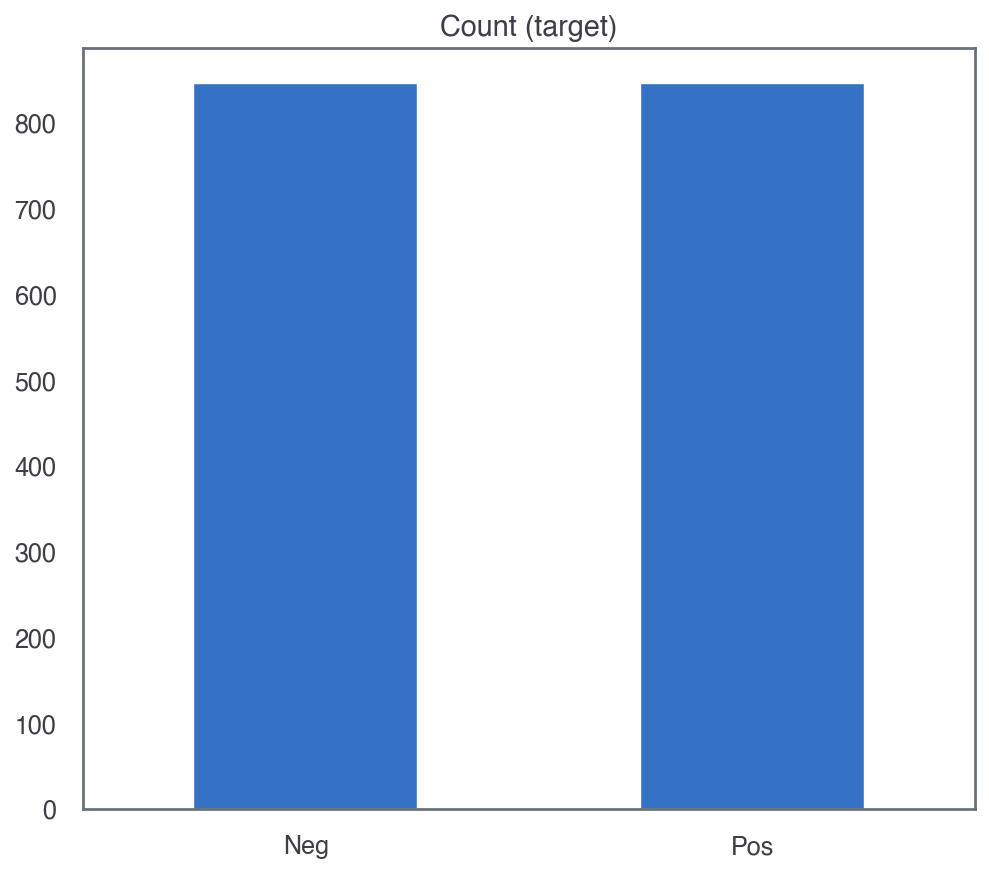

In [307]:
# New DF with a random sample (of the same length as the neg_count) of the old DF with just 'pos'
df_pos_under = df_class_pos.sample(neg_count)

# New DF that joins the pos and neg, now of the same length
df_under_1 = pd.concat([df_pos_under, df_class_neg], axis = 0)

# Resetting the index cuz I want to
df_under_1.reset_index(drop = True, inplace = True)

print('Random under-sampling:')
print(df_under_1['Target'].value_counts())

df_under_1['Target'].value_counts().plot(kind = 'bar', title = 'Count (target)', rot = 0);

In [304]:
df_under_1#['Target'].value_counts()

,Title,Platform,Userscore,Comment,Username,Comments_Processed,Target,Target_2,Target_3,Target_4
0,Half-Life 2,PC,10,Its the best game with the best story and pic...,LennyJ.,"[best, game, best, stori, pictur]",Pos,Positive,Positive,Positive
1,Batman: Arkham Knight,XboxOne,6,Asylum and City had amazing dynamic super vill...,HarryManback,"[asylum, citi, amaz, dynam, super, villain, fi...",Pos,Neutral,Negative,Negative
2,Madden NFL 2004,Xbox,9,"No *&#$)@ xbox live, and no 10's till it's th...",MatC.,"[xbox, live, till]",Pos,Positive,Positive,Positive
3,Battlefield 3,Xbox360,8,this game is really fun once you unlock more t...,SleepingPillow,"[thi, game, realli, fun, onc, unlock, thing, o...",Pos,Neutral,Negative,Positive
4,The Legend of Zelda: Ocarina of Time / Master ...,GameCube,10,This was the very first time i ever played ze...,NickF.,"[thi, wa, veri, first, time, ever, play, zelda...",Pos,Positive,Positive,Positive
...,...,...,...,...,...,...,...,...,...,...
1685,Call of Duty: Black Ops III,XboxOne,0,"Well, is not a bad game, even I enjoy it more ...",Deather2012,"[well, bad, game, even, enjoy, past, titl, cas...",Neg,Negative,Negative,Negative
1686,The Binding of Isaac: Rebirth,PC,0,"The game no longer has mouse aiming. In fact,...",deskrit,"[game, longer, ha, mous, aim, fact, mous, comp...",Neg,Negative,Negative,Negative
1687,Call of Duty: Modern Warfare 3,PlayStation3,3,Buying Modern Warfare 3 this year is like wipi...,blackmagicmarkr,"[buy, modern, warfar, thi, year, like, wipe, b...",Neg,Negative,Negative,Negative
1688,Halo 4,Xbox360,2,Had high hopes for this game but the multiplay...,spartan117357,"[high, hope, thi, game, multiplay, doesnt, fee...",Neg,Negative,Negative,Negative


### TESTING AGAIN WITH UNDER-SAMPLED DATA

In [308]:
# Building the features and making the matrix
matrix_under_samp = make_matrix(df_under_1['Comment'], df_under_1['Target'], most_common)

# Defining the size to use for the training and testing
size_under_samp = int(len(matrix_under_samp) * 0.20)

# Training with 80% of the data and testing against the remaining 20%
training_set_under_samp = matrix_under_samp[size_under_samp:]
testing_set_under_samp = matrix_under_samp[:size_under_samp]

# Initializing and training the model
classifier_under_samp = nltk.NaiveBayesClassifier.train(training_set_under_samp)

# Showing the top 15 most informative features
classifier_under_samp.show_most_informative_features(15)

# Printing the model's accuracy
print('\n', 'Original NLTK NB accuracy (Target):', 
      str(round(nltk.classify.accuracy(classifier_under_samp, testing_set_under_samp) * 100, 2)) + '%')

Most Informative Features
                  addict = True              Pos : Neg    =     13.7 : 1.0
                  batman = True              Pos : Neg    =     11.7 : 1.0
                   worst = True              Neg : Pos    =     11.0 : 1.0
                  portal = True              Pos : Neg    =     10.5 : 1.0
                    poca = True              Pos : Neg    =     10.5 : 1.0
                   notch = True              Pos : Neg    =     10.5 : 1.0
                    wast = True              Neg : Pos    =     10.5 : 1.0
                    skip = True              Neg : Pos    =      9.8 : 1.0
                    flow = True              Pos : Neg    =      8.3 : 1.0
                    kart = True              Pos : Neg    =      8.3 : 1.0
                  accept = True              Neg : Pos    =      8.2 : 1.0
                   trash = True              Neg : Pos    =      7.8 : 1.0
                    wors = True              Neg : Pos    =      7.5 : 1.0

In [539]:
bad_sentence = find_features('This game sucks so much. I hate it a lot. This is complete garbage', most_common)
print(classifier_under_samp.classify(bad_sentence))
# Ok, it still said it is positive, so... I'm done. Don't know what else to do D:

Pos


## Testing with other models

Discarded Bernoulli NB, default accuracy was only 59.2%.

NuSVC didn't work.

### Multinomial NB

In [334]:
# UNDER-SAMPLING TEST
MNB_classifier_under_samp = SklearnClassifier(MultinomialNB())  # fit_prior = False - 71.6%
MNB_classifier_under_samp.train(training_set_under_samp)

print('MultinomialNB accuracy (Target) UNDER SAMP:', 
      str(round(nltk.classify.accuracy(MNB_classifier_under_samp, testing_set_under_samp) * 100, 2)) + '%')
# lol got a worse score this time than the NLTK one...

MultinomialNB accuracy (Target) UNDER SAMP: 70.12%


In [540]:
#under_test_pred_MNB = find_features('This game sucks so much. I hate it a lot. This is complete garbage', most_common)
print(MNB_classifier_under_samp.classify(bad_sentence))
# OMGGGGG this one at least finally said this god damn sentence is negative!!!

Neg


In [562]:
# TESTING WITH TARGET_NPS
MNB_classifier_NPS = SklearnClassifier(MultinomialNB(alpha = 2))
MNB_classifier_NPS.train(training_set_NPS)

print('MultinomialNB accuracy (Target_NPS):', 
      str(round(nltk.classify.accuracy(MNB_classifier_NPS, testing_set_NPS) * 100, 2)) + '%')
# default: 68.3% - seems ok?
# alpha = 2: 69.4%

# I will probably use this one I guess, if nothing else better comes along

MultinomialNB accuracy (Target_NPS): 69.4%


In [563]:
print(MNB_classifier_NPS.classify(bad_sentence))  # negative, yesssss

Negative


In [564]:
# Predictions of the testing_set with the Target_NPS column
pred_list_MNB_NPS = [MNB_classifier_NPS.classify(testing_set_NPS[i][0]) for i in range(len(testing_set_NPS))]
print(pred_list_MNB_NPS.count('Positive'))  # 695
print(pred_list_MNB_NPS.count('Negative'))  # 204
print(pred_list_MNB_NPS.count('Neutral'))  # 101

695
204
101


In [572]:
# Testing the Multinomial NB model with Target_3 column
MNB_classifier_3 = SklearnClassifier(MultinomialNB())
MNB_classifier_3.train(training_set_3)

print('MultinomialNB accuracy (Target_3):', 
      str(round(nltk.classify.accuracy(MNB_classifier_3, testing_set_3) * 100, 2)) + '%')

MultinomialNB accuracy (Target_3): 73.8%


In [588]:
print(MNB_classifier_3.classify(bad_sentence))

Negative


In [573]:
df['Target_3'].value_counts()

Positive    2970
Negative    2030
Name: Target_3, dtype: int64

### Under-sampling Target_3

In [ ]:
# UNDER-SAMPLING A NEW DF FOR TARGET_3 TESTING
df_3_pos = df[df['Target_3'] == 'Positive']
df_3_neg = df[df['Target_3'] == 'Negative']

df_3_pos_under = df_3_pos.sample(2030)

df_3_under = pd.concat([df_3_pos_under, df_3_neg])

In [582]:
df_3_under['Target_3'].value_counts()  # perfectly balanced now

Positive    2030
Negative    2030
Name: Target_3, dtype: int64

In [587]:
# Testing the Multinomial NB model with Target_3 UNDER-SAMPLED DF column

# Building the features and making the matrix
matrix_3_under = make_matrix(df_3_under['Comment'], df_3_under['Target_3'], most_common)

# Defining the size to use for the training and testing
size_3_under = int(len(matrix_3_under) * 0.20)

# Training with 80% of the data and testing against the remaining 20%
training_set_3_under = matrix_3_under[size_3_under:]
testing_set_3_under = matrix_3_under[:size_3_under]



MNB_classifier_3_under = SklearnClassifier(MultinomialNB())
MNB_classifier_3_under.train(training_set_3_under)

print('MultinomialNB accuracy (Target_3) UNDER-SAMPLED:', 
      str(round(nltk.classify.accuracy(MNB_classifier_3_under, testing_set_3_under) * 100, 2)) + '%')
# score went from 73.8% to 77.83%

MultinomialNB accuracy (Target_3) UNDER-SAMPLED: 77.83%


### Logistic Regression

In [585]:
# Testing with normal Target_3
LogisticRegression_classifier_3 = SklearnClassifier(LogisticRegression(solver = 'saga'))
LogisticRegression_classifier_3.train(training_set_3)

print('Logistic Regression accuracy (Target_3):', 
      str(round(nltk.classify.accuracy(LogisticRegression_classifier_3, testing_set_3) * 100, 2)) + '%')

/Users/mattymrc/.pyenv/versions/3.7.5/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Logistic Regression accuracy (Target_3): 76.5%


In [586]:
# Testing with Target_3_under UNDER-SAMPLED VERSION
LogisticRegression_classifier_3_under = SklearnClassifier(LogisticRegression(solver = 'saga'))
LogisticRegression_classifier_3_under.train(training_set_3_under)

print('Logistic Regression accuracy (Target_3) UNDER-SAMPLED:', 
      str(round(nltk.classify.accuracy(LogisticRegression_classifier_3_under, testing_set_3_under) * 100, 2)) + '%')

# oh well, this was unexpected. Quite a big drop from 76.5% to 65.89% with the under-sampled version

/Users/mattymrc/.pyenv/versions/3.7.5/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Logistic Regression accuracy (Target_3) UNDER-SAMPLED: 65.89%


In [570]:
# Testing with Target_NPS
LogisticRegression_classifier_NPS = SklearnClassifier(LogisticRegression(solver = 'saga'))
## all default - 68.7%
## max_iter = 300 - 68.4% (0.3% decrease)
## saga solver = 70.6% - best so far, apart from SVC
LogisticRegression_classifier_NPS.train(training_set_NPS)

print('Logistic Regression accuracy (Target_NPS):', 
      str(round(nltk.classify.accuracy(LogisticRegression_classifier_NPS, testing_set_NPS) * 100, 2)) + '%')

/Users/mattymrc/.pyenv/versions/3.7.5/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Logistic Regression accuracy (Target_NPS): 70.5%


In [571]:
print(LogisticRegression_classifier_NPS.classify(bad_sentence))

Negative


### SGD Classifier

In [545]:
SGDClassifier_classifier = SklearnClassifier(SGDClassifier())
SGDClassifier_classifier.train(training_set_NPS)

print('SGDClassifier_classifier accuracy (Target_NPS):', 
      str(round(nltk.classify.accuracy(SGDClassifier_classifier, testing_set_NPS) * 100, 2)) + '%')

SGDClassifier_classifier accuracy (Target_NPS): 65.9%


### SVC

In [546]:
SVC_classifier = SklearnClassifier(SVC())
SVC_classifier.train(training_set_NPS)

print('SVC_classifier accuracy (Target_NPS):', 
      str(round(nltk.classify.accuracy(SVC_classifier, testing_set_NPS) * 100, 2)) + '%')
# 72.8% - seems like it's the best one! However, this is probablity horrible for large datasets
## as it will take forever to finish. They even advise using linear svc or SGD instead...

SVC_classifier accuracy (Target_NPS): 72.8%


### Linear SVC

In [547]:
LinearSVC_classifier = SklearnClassifier(LinearSVC())
LinearSVC_classifier.train(training_set_NPS)

print('LinearSVC_classifier accuracy (Target_NPS):', 
      str(round(nltk.classify.accuracy(LinearSVC_classifier, testing_set_NPS) * 100, 2)) + '%')

/Users/mattymrc/.pyenv/versions/3.7.5/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC_classifier accuracy (Target_NPS): 67.0%
